# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import numpy
import math
import shap 
import tensorflow as tf
import matplotlib.pyplot as plt
import lightgbm as ltb

from functools import reduce
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

numpy.set_printoptions(threshold=sys.maxsize)


2022-03-07 02:09:19.530812: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kali/.local/lib/python3.9/site-packages/cv2/../../lib64:
2022-03-07 02:09:19.534398: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data_dka.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data

df.drop(df[df.DKAPast12mos == 2].index, inplace=True)


In [5]:
df1 = df.loc[(df['DKAPast12mos'] ==0 ) & (df['Pt_HospDKASinceDiag'] == 0)]
len(df1)

23

### for DKA events prediction pre processing


In [6]:
y_label = 'DKAPast12mos' 

In [7]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['DKAPast12mos'])):
        if((row['NumDKAOccur'] >= 1) or (row['Pt_NumHospDKA']>=1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [8]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# DKADiag {'1.Yes': 0, '2.Probably Yes': 1, '3.No': 2, '4.Unknown': 3}
df['DKADiag'] = df['DKADiag'].replace({1.0: 0.0, 2.0:1.0, 3.0:1.0})
    
get_possible_vals_with_nan(df, 'DKADiag')


[1.0, 0.0]

In [9]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'ReqInsulinCrit', 'DKADiag', 'Or

In [10]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater']


df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,CancPros,CancThyr,CancOth,Insulin_Glargine,Insulin_Lispro,Hydrochlorothiazide,Sertraline,Insulin_Aspart_Human,diagDuration,education_level
0,3963.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,12505.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
7,26063.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,553.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,13365.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,15799.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,15966.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,6426.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,10659.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
40,19861.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.6872,10.0


In [11]:
# gender specific data
# number of F and M
# check gender distribution of selected dataset  Gender {'F': 0, 'M': 1, 'T': 2}

gender_groupby = df.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)

   Gender  total
0     0.0   3353
1     1.0   2816
2     2.0      2


In [12]:
# patient count with both SH and DKA in past 12 months

both_sh_dka_ever = df.loc[(df['DKADiag']==0.0) & (df['Pt_SevHypoEver'] == 0.0) ].shape[0]
both_12_mon =  df.loc[(df['DKAPast12mos']==0.0) & (df['SHSeizComaPast12mos'] == 0.0) ].shape[0]

print('patients with sh and dka both ever: ', both_sh_dka_ever)
print('patients with sh and dka both within 12 months: ', both_12_mon)

patients with sh and dka both ever:  242
patients with sh and dka both within 12 months:  12


In [13]:
# only SH event occured 
is_male = False
if is_male:
    gender_label = 1.0
else:
    gender_label = 0.0

df_sh = df[df[y_label]== gender_label]
gender_groupby = df_sh.groupby('Gender', as_index=False).agg(total= ('PtID','count'))
print(gender_groupby)
print(df.shape)
df = df[df['Gender'] == gender_label]
df.shape

   Gender  total
0     0.0    123
1     1.0     77
(6171, 213)


(3353, 213)

In [14]:
def remove_gender_specific_fields(df):
    if is_male:
        drop_list = ['Pt_MenarcheAge','Pt_RegMenstCyc','Pt_IrregMenstCycReas','Pt_CurrPreg','Pt_MiscarriageNum']
        df = df.drop(drop_list, axis = 1)
        return df
    else:
        return df

df = remove_gender_specific_fields(df)

# Divide Dataset

In [15]:
df=df.drop('PtID', axis = 1)

In [16]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [17]:

df.drop(['Lipoatrophy',
 'AgeAtConsent',
 'InsCarbRatDinn',
 'InsNovolog',
 'CGMGlucPctBelow60'], inplace=True, axis=1)
df.head(10)


,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,Pt_InsUnk,...,CancPros,CancThyr,CancOth,Insulin_Glargine,Insulin_Lispro,Hydrochlorothiazide,Sertraline,Insulin_Aspart_Human,diagDuration,education_level
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
14,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
20,3.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
61,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3799,NaN
62,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.6249,13.0
91,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.4791,12.0
93,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.3073,10.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.2854,11.0


In [18]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [19]:
Y.unique()

array([1., 0.])

# Feature Selection

In [20]:
shape = np.shape(X) 
feature = 25 #shape[1] 
n_classes = 2


In [21]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)


# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [22]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [  92 2422]
Test -  [0. 1.] [ 31 808]


# Imputations

<AxesSubplot:>

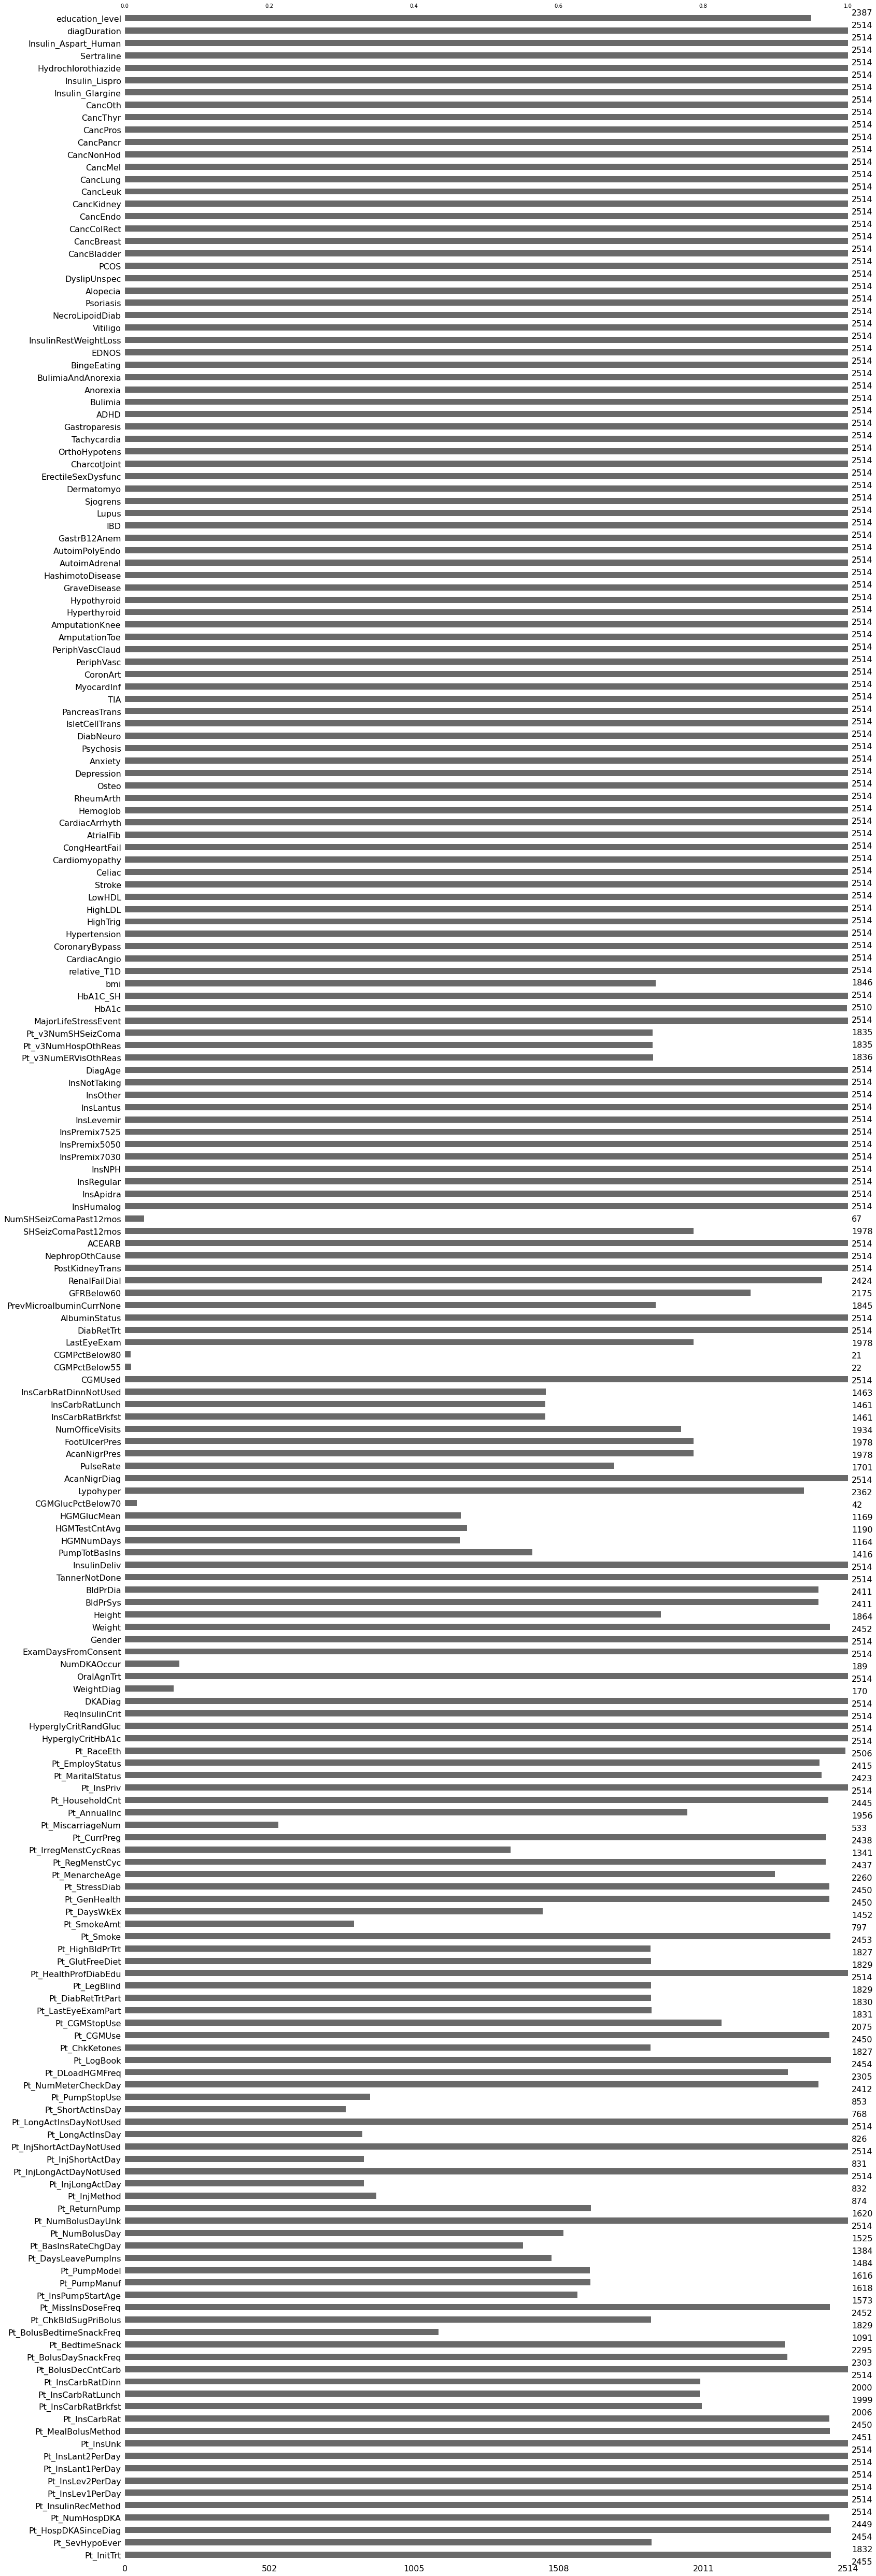

In [23]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [24]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [25]:
# use only for XGB classifier with missing values
# X_train_copy = X_train.drop(['NumDKAOccur', 'Pt_NumHospDKA'], axis=1)
# X_test_copy = X_test.drop(['NumDKAOccur', 'Pt_NumHospDKA'], axis=1)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()


if('NumDKAOccur' in X_train.columns):
    X_train_copy = X_train_copy.drop(['NumDKAOccur'], axis=1)
    X_test_copy = X_test_copy.drop([ 'NumDKAOccur'], axis=1)

if('Pt_NumHospDKA' in X_train.columns):
    X_train_copy = X_train_copy.drop(['Pt_NumHospDKA'], axis=1)
    X_test_copy = X_test_copy.drop(['Pt_NumHospDKA'], axis=1)

# if('Pt_HospDKASinceDiag' in X_train.columns):
#     X_train_copy = X_train_copy.drop(['Pt_HospDKASinceDiag'], axis=1)
#     X_test_copy = X_test_copy.drop(['Pt_HospDKASinceDiag'], axis=1)


features_set = ['Pt_HospDKASinceDiag','Pt_PumpManuf','Pt_InsLant1PerDay','Pt_LogBook','Pt_RegMenstCyc','WeightDiag',
'Pt_InsLev2PerDay','Pt_GenHealth','Insulin_Lispro' ,'Pt_v3NumHospOthReas','AlbuminStatus','Depression',
'Pt_RaceEth','InsHumalog','Pt_ChkKetones'  ,'diagDuration' ,'Pt_SmokeAmt','Pt_DaysLeavePumpIns' ,'AcanNigrDiag',
'Pt_AnnualInc' ,'Pt_v3NumERVisOthReas','Pt_v3NumSHSeizComa','Pt_BolusDecCntCarb','Cardiomyopathy' ,
'education_level']



# X_train_copy = X_train_copy[features_set]
# X_test_copy = X_test_copy[features_set]

In [26]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values

def cross_val_with_missing_val(model):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


Accuracy for the fold no. 1 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 2 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 3 on the test set: 0.9563492063492064, doublecheck: 0.9563492063492064
Accuracy for the fold no. 4 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 5 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 6 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 7 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 8 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 9 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 10 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207

 
 ===========   Train Datas

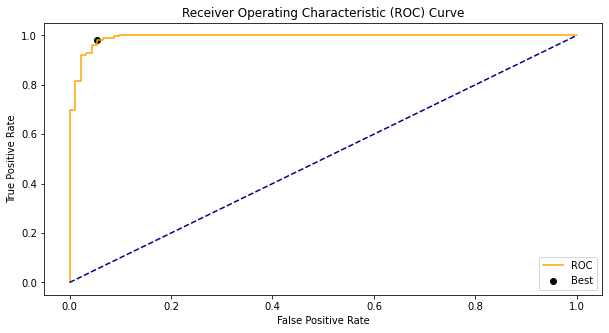

accuracy score:  98.09069212410502
              precision    recall  f1-score   support

         0.0       0.67      0.95      0.78        92
         1.0       1.00      0.98      0.99      2422

    accuracy                           0.98      2514
   macro avg       0.83      0.96      0.89      2514
weighted avg       0.99      0.98      0.98      2514



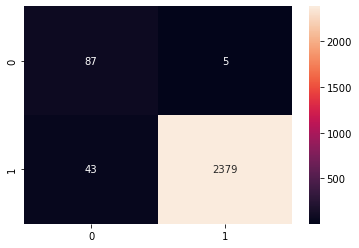

Accuracy of XGB on training set: 1.00


 ===========   Test Dataset    =============
Threshold value is: 0.9977161219655972


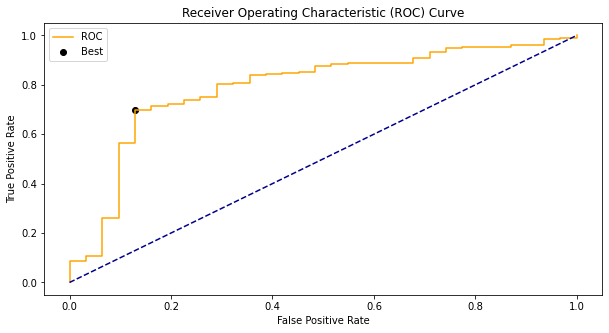

accuracy score:  70.32181168057211
              precision    recall  f1-score   support

         0.0       0.10      0.87      0.18        31
         1.0       0.99      0.70      0.82       808

    accuracy                           0.70       839
   macro avg       0.55      0.78      0.50       839
weighted avg       0.96      0.70      0.80       839



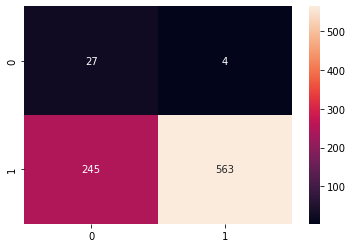

Accuracy of XGB classifier on test set: 0.96


 ===========   ROC    =============
roc_auc = 0.7902


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.87096774 0.69678218]
average accuracy:  0.7838749600766528


In [27]:
# xgboost - train with missing values
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


model= HistGradientBoostingClassifier(loss= 'binary_crossentropy',
                                     learning_rate = 0.1,
                                     max_iter= 50,
                                     )          
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)




In [28]:
model.n_features_in_

204

Accuracy for the fold no. 1 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 2 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 3 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 4 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 5 on the test set: 0.9482071713147411, doublecheck: 0.9482071713147411
Accuracy for the fold no. 6 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 7 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 8 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 9 on the test set: 0.9681274900398407, doublecheck: 0.9681274900398407
Accuracy for the fold no. 10 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207

 
 ===========   Train Datas

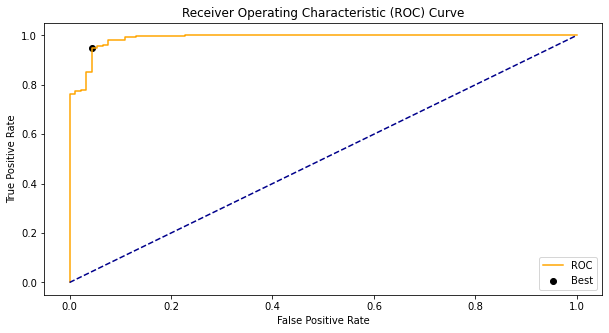

accuracy score:  94.94828957836118
              precision    recall  f1-score   support

         0.0       0.42      0.96      0.58        92
         1.0       1.00      0.95      0.97      2422

    accuracy                           0.95      2514
   macro avg       0.71      0.95      0.78      2514
weighted avg       0.98      0.95      0.96      2514



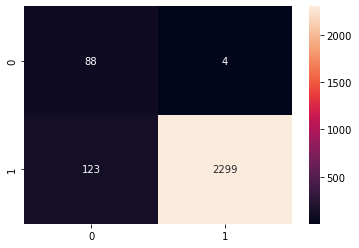

Accuracy of XGB on training set: 0.98


 ===========   Test Dataset    =============
Threshold value is: 2.6761236


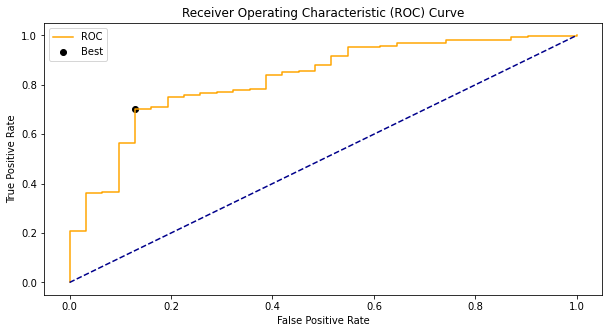

accuracy score:  70.79856972586413
              precision    recall  f1-score   support

         0.0       0.10      0.87      0.18        31
         1.0       0.99      0.70      0.82       808

    accuracy                           0.71       839
   macro avg       0.55      0.79      0.50       839
weighted avg       0.96      0.71      0.80       839



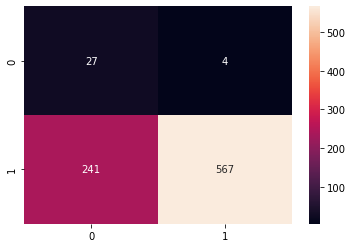

Accuracy of XGB classifier on test set: 0.96


 ===========   ROC    =============
roc_auc = 0.8241


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.87096774 0.70173267]
average accuracy:  0.7863502076014053
f1 0.8223350253807106


In [29]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 3, #values between(3-10)
        max_delta_step = 10,
# #         scale_pos_weight = 0.4,
# #         n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
        min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)

print('f1', metrics.f1_score(xgb_pred, Y_test))


<AxesSubplot:>

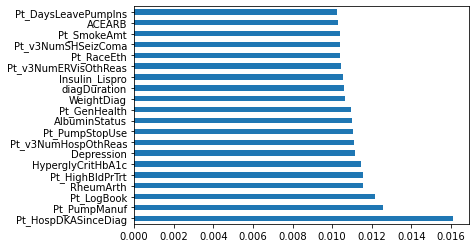

In [30]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
feat_importances.nlargest(20).plot(kind='barh')

In [31]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Positive', alpha=1, color='b', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Negative', alpha=0.5, color='r', density=True)
    plt.xlabel('Probability of being Positive Class', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.DKAPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)
    plt.axhline(y=thresh1)
    plt.axhline(y=thresh2)
    plt.xlabel('sample', fontsize=10)
    plt.ylabel('probability', fontsize=10)
    plt.show()

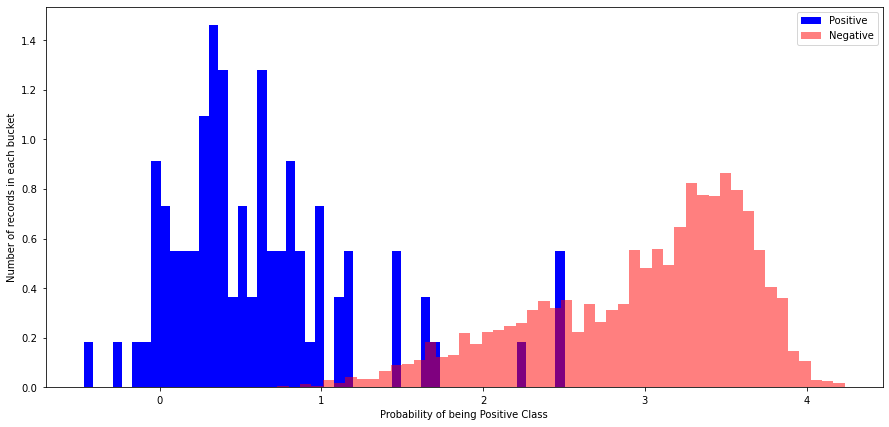

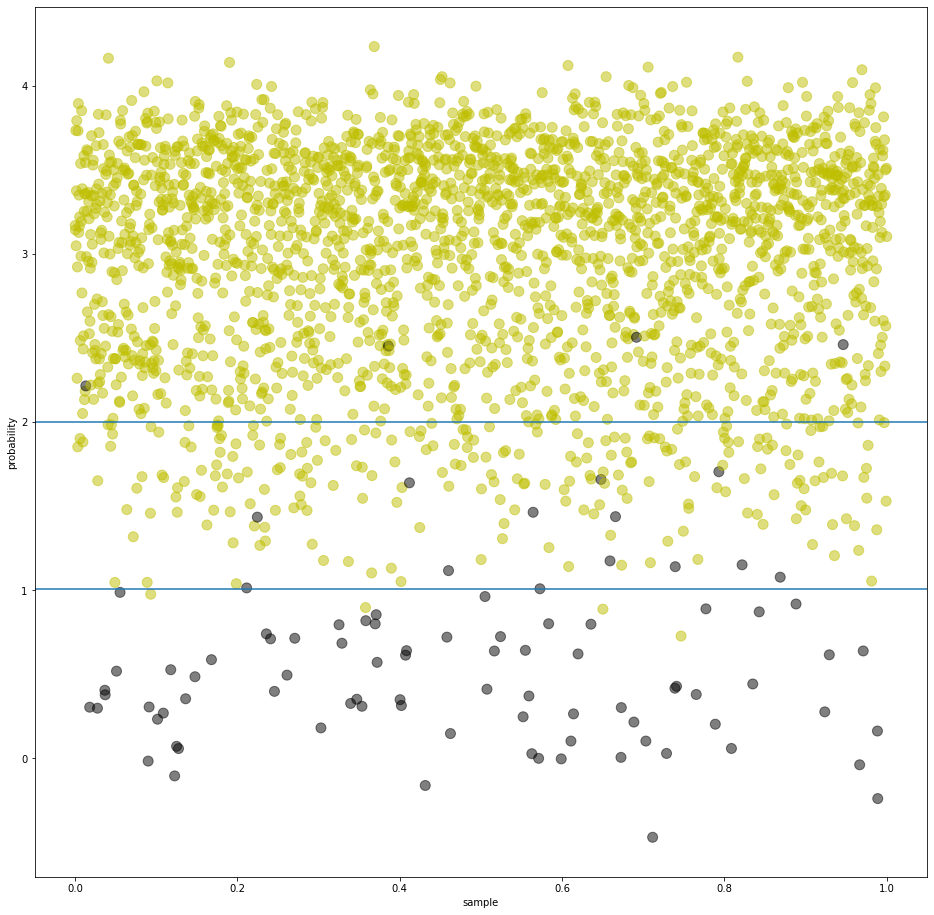

In [32]:
patients_count = X_train.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 1.5
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[no_patients-1],2)
    return threshold
    
thresh1 = get_optimal_threshold(model, X_train_copy, 8000, 100)
thresh2 = 2.0
draw_boundary(model, X_train_copy, Y_train, thresh1, thresh2)

In [33]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label


In [34]:

row_to_show = 93
data_for_prediction = X_test_copy.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
model.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction, link='logit')

predictoin [0]
actial 1.0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [35]:
# compute SHAP values
explainer = shap.Explainer(model, X_train_copy)
shap_values = explainer(X_train_copy)

 99%|===================| 4989/5028 [00:40<00:00]        

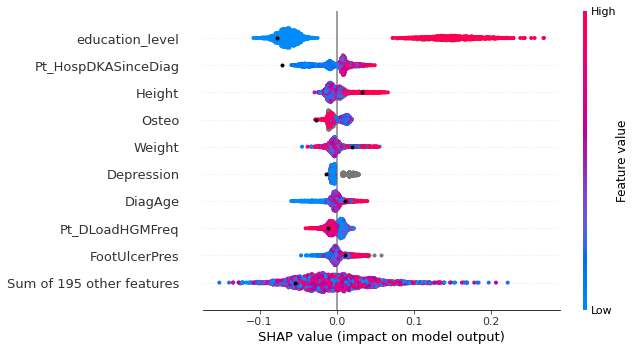

In [36]:
shap_val = shap_values[:, :, 0]
# shap.plots.beeswarm(shap_val)

import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_val, show=False)
shap.plots.beeswarm(shap_val[-1:], show=False, color="black")
pl.show()

In [37]:

Y_train = pd.DataFrame(Y_train)
pred = model.predict_proba(X_train_copy)[:,1] 
X_beeswarm = X_train_copy.copy()
X_beeswarm['pred'] = pred
# X_beeswarm['Y'] = Y_train
X_beeswarm['Y'] = Y_train['DKAPast12mos'].to_list()


In [38]:
idx = np.where((X_beeswarm['pred']>2) & (X_beeswarm['Y']== 0.0) )
print(idx)

idx2 = np.where((X_beeswarm['pred']<0) & (X_beeswarm['Y']== 0.0) )
print(idx2)
X_beeswarm.drop(['pred'], axis = 1)
X_beeswarm.drop(['Y'], axis = 1)

explainer = shap.Explainer(model, X_beeswarm)
shap_values = explainer(X_beeswarm)
shap_val = shap_values[:, :, 0]


(array([  33,  970, 1738, 2378]),)
(array([ 226,  308, 1084, 1505, 1788, 2429, 2485]),)


 99%|===================| 5000/5028 [00:38<00:00]        

In [39]:
pd.DataFrame(X_beeswarm)['Height'].iloc[2378]

1.5875

In [40]:
X_beeswarm = pd.DataFrame(X_beeswarm)
X_beeswarm['Height'].nsmallest(3)


25277    0.6500
15911    1.3208
1549     1.3716
Name: Height, dtype: float64

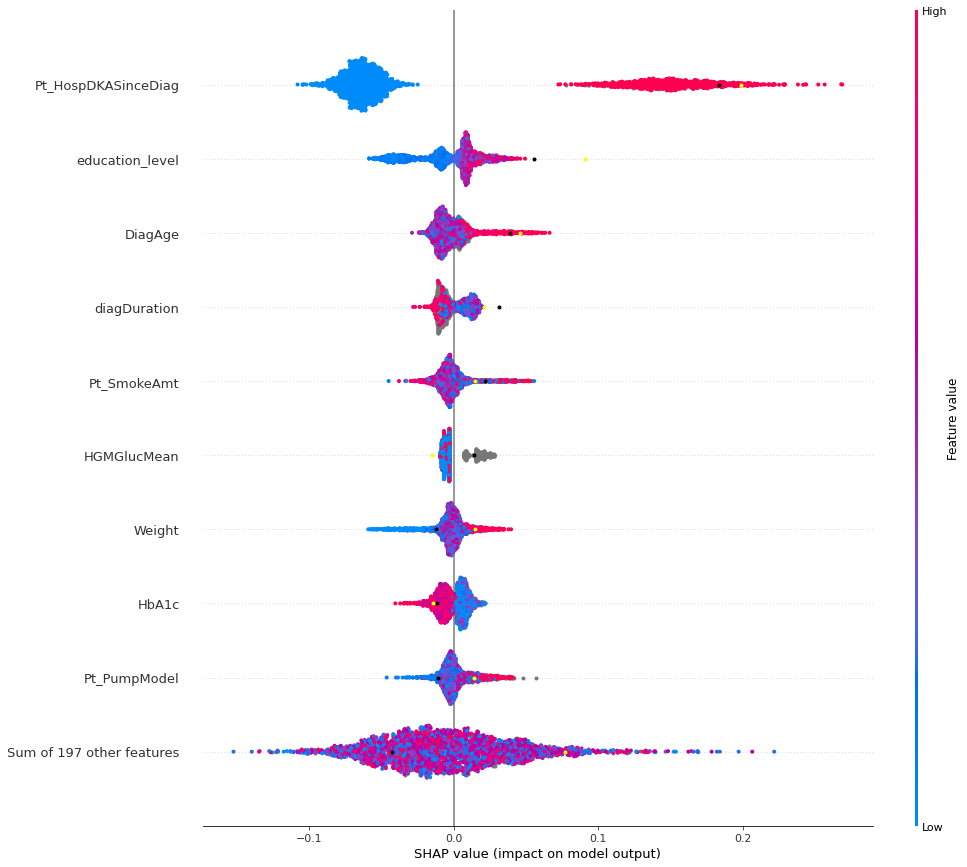

In [41]:

shap.plots.beeswarm(shap_val, show=False, plot_size=[15,15],  max_display=10, alpha = 1)
shap.plots.beeswarm(shap_val[33:34:], show=False, color="black", plot_size=[15,15])
# shap.plots.beeswarm(shap_val[970:971:], show=False, color="black", plot_size=[15,15])
# shap.plots.beeswarm(shap_val[226:227:], show=False, color="white", plot_size=[15,15])
shap.plots.beeswarm(shap_val[308:309:], show=False, color="yellow", plot_size=[15,15])\

plt.show()


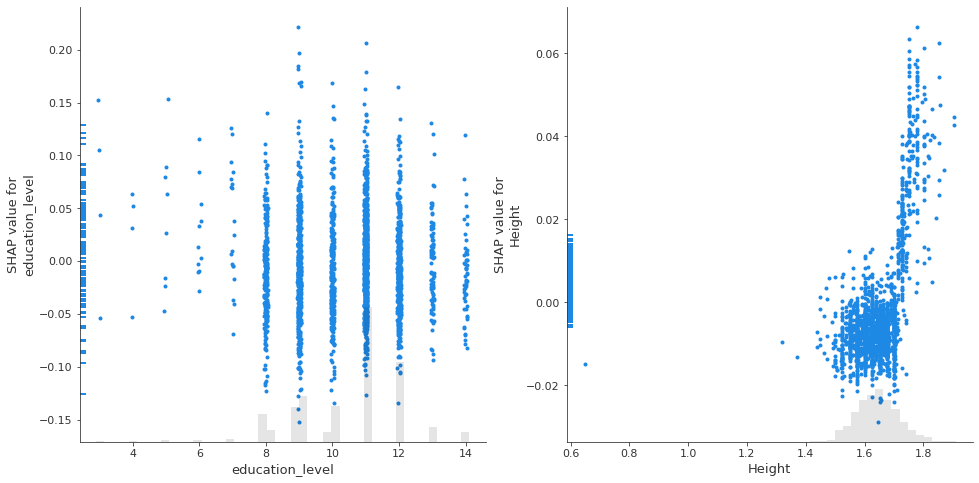

In [42]:

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

#SHAP scatter plots
shap.plots.scatter(shap_val[:,"education_level"],ax=ax[0],show=False)
shap.plots.scatter(shap_val[:,"Height"],ax=ax[1])

In this chart, the x-axis stands for SHAP value, and the y-axis has all the features. Each point on the chart is one SHAP value for a prediction and feature. Red color means higher value of a feature. Blue means lower value of a feature. We can get the general sense of features’ directionality impact based on the distribution of the red and blue dots

### LGBM Classifier with missing values

Accuracy for the fold no. 1 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 2 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 3 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 4 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 5 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 6 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 7 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 8 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 9 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 10 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207

 
 ===========   Train Datas

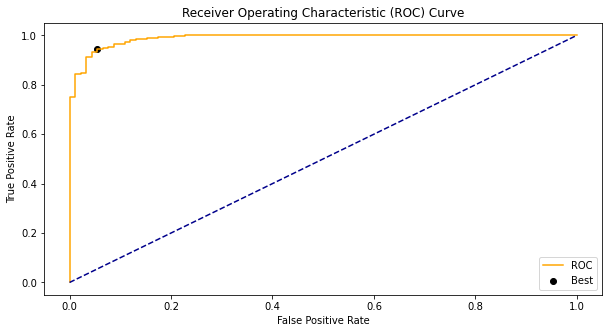

accuracy score:  94.5505171042164
              precision    recall  f1-score   support

         0.0       0.40      0.95      0.56        92
         1.0       1.00      0.95      0.97      2422

    accuracy                           0.95      2514
   macro avg       0.70      0.95      0.77      2514
weighted avg       0.98      0.95      0.96      2514



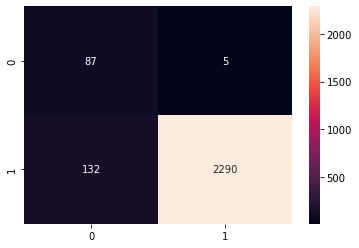

Accuracy of XGB on training set: 0.96


 ===========   Test Dataset    =============
Threshold value is: 0.9774254716548076


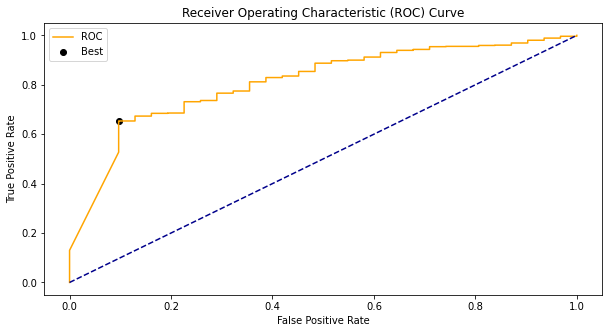

accuracy score:  66.26936829559
              precision    recall  f1-score   support

         0.0       0.09      0.90      0.17        31
         1.0       0.99      0.65      0.79       808

    accuracy                           0.66       839
   macro avg       0.54      0.78      0.48       839
weighted avg       0.96      0.66      0.77       839



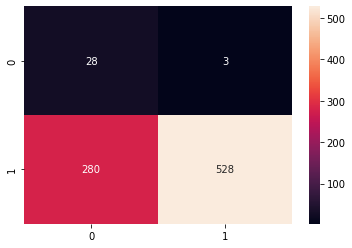

Accuracy of XGB classifier on test set: 0.96


 ===========   ROC    =============
roc_auc = 0.8113


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.90322581 0.65346535]
average accuracy:  0.7783455764931332
f1 0.7886482449589246


In [43]:

import lightgbm as ltb

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.01, 
                         max_depth =5, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

<AxesSubplot:>

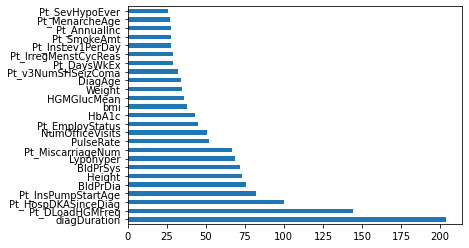

In [44]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:250])
feat_importances.nlargest(25).plot(kind='barh')

In [45]:
if is_male:
    
    X_train.update(X_train[[
                 'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
                 'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
                 'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
                 ]].fillna(0))

    X_test.update(X_test[[
                 'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
                 'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
                 'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
                 ]].fillna(0))
else:
    X_train.update(X_train[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
             ]].fillna(0))

    X_test.update(X_test[[
             'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
             'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
             ]].fillna(0))
    

In [46]:
# X_train = X_train_copy
# X_test = X_test_copy

In [47]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [48]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)





# Scale data

In [49]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))


## Feature Selection

In [50]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [51]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])

    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [52]:
# Feature selection
selected, fs, idx = select_features(select, feature)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:16:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[02:17:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [53]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

Index(['Pt_InitTrt', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA',
       'Pt_MealBolusMethod', 'Pt_InsCarbRatDinn', 'Pt_PumpModel',
       'Pt_ShortActInsDay', 'Pt_ChkKetones', 'Pt_AnnualInc',
       'Pt_MaritalStatus', 'OralAgnTrt', 'NumDKAOccur', 'ExamDaysFromConsent',
       'Height', 'BldPrSys', 'LastEyeExam', 'DiagAge', 'HbA1c',
       'Cardiomyopathy', 'Osteo', 'Psychosis', 'Hypothyroid', 'ADHD',
       'diagDuration', 'education_level'],
      dtype='object')
(3353, 25)


In [54]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [55]:

if('NumDKAOccur' in X_train.columns):
    X_train = X_train.drop(['NumDKAOccur'], axis=1)
    X_test = X_test.drop([ 'NumDKAOccur'], axis=1)

if('Pt_NumHospDKA' in X_train.columns):
    X_train = X_train.drop(['Pt_NumHospDKA'], axis=1)
    X_test = X_test.drop([ 'Pt_NumHospDKA'], axis=1)

# if('Pt_HospDKASinceDiag' in X_train.columns):
#     X_train = X_train.drop(['Pt_HospDKASinceDiag'], axis=1)
#     X_test = X_test.drop([ 'Pt_HospDKASinceDiag'], axis=1)


### Common functions

In [56]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_ test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



In [57]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr, optimal_idx)
    return optimal_threshold

In [58]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))

Accuracy for the fold no. 1 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 2 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 3 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 4 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 5 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 6 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 7 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 8 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 9 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 10 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
0.7991256786969019
Threshold 

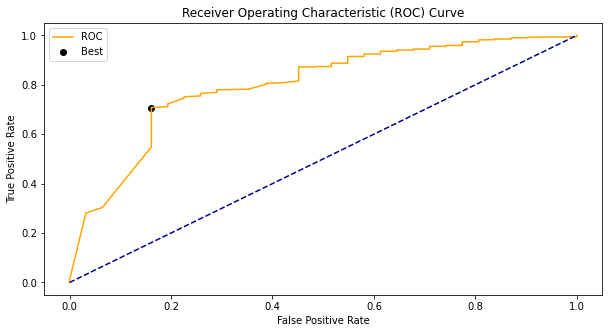

0.9190751445086707
Threshold value is: 0.9516333914116533


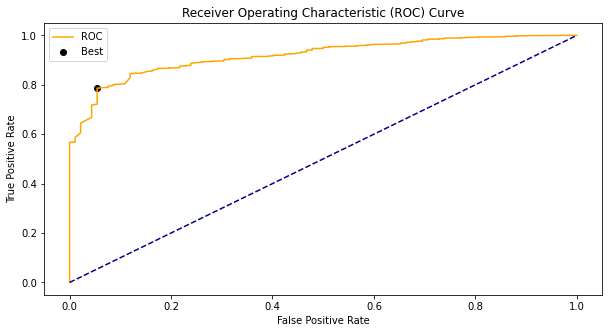


 
 =====================   Train Dataset    ======================
79.19649960222752
              precision    recall  f1-score   support

         0.0       0.14      0.95      0.25        92
         1.0       1.00      0.79      0.88      2422

    accuracy                           0.79      2514
   macro avg       0.57      0.87      0.56      2514
weighted avg       0.97      0.79      0.86      2514



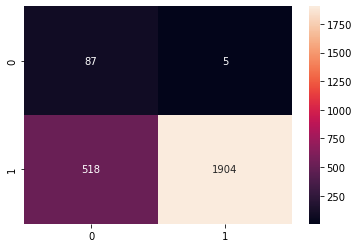

Accuracy of on training set: 0.96


 =====================   Test Dataset    =======================
71.27532777115614
              precision    recall  f1-score   support

         0.0       0.10      0.84      0.18        31
         1.0       0.99      0.71      0.83       808

    accuracy                           0.71       839
   macro avg       0.55      0.77      0.50       839
weighted avg       0.96      0.71      0.80       839



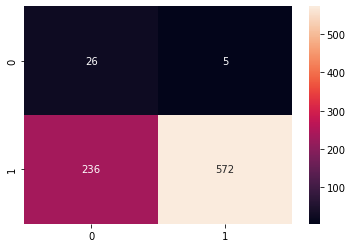

Accuracy of classifier on test set: 0.96


 =======================   Test-ROC    =========================
roc_auc = 0.7991


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.83870968 0.70792079]
average accuracy:  0.7733152347492813


In [59]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model = ltb.LGBMClassifier(use_missing = False,
                         learning_rate = 0.01, 
                         max_depth =3, random_state=0 )
# ltb_model.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model)

# pred=ltb_model.predict(X_test)
# pred_train=ltb_model.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)


<AxesSubplot:>

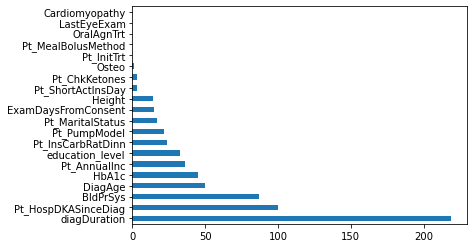

In [60]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 2 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 3 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 4 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 5 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 6 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 7 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 8 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 9 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 10 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
0.7777467262855319
Threshold 

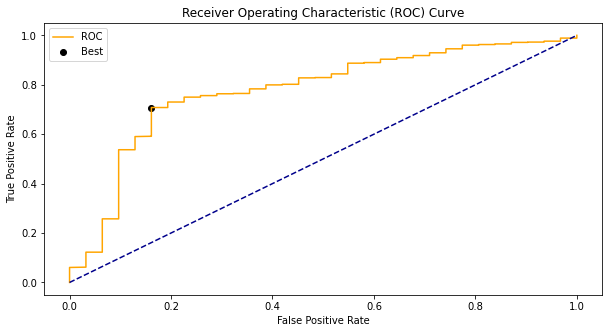

0.917959914551395
Threshold value is: 0.5395075200900975


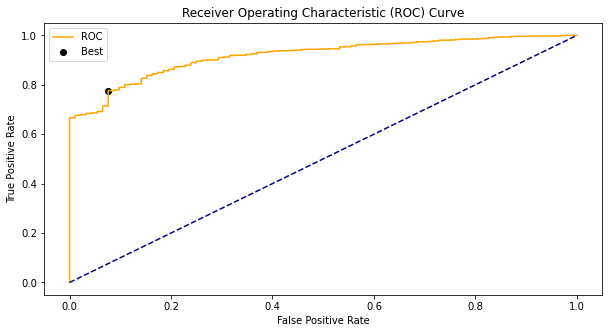


 
 =====================   Train Dataset    ======================
78.16229116945107
              precision    recall  f1-score   support

         0.0       0.14      0.92      0.24        92
         1.0       1.00      0.78      0.87      2422

    accuracy                           0.78      2514
   macro avg       0.57      0.85      0.55      2514
weighted avg       0.96      0.78      0.85      2514



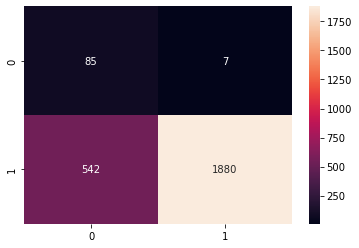

Accuracy of on training set: 0.96


 =====================   Test Dataset    =======================
71.27532777115614
              precision    recall  f1-score   support

         0.0       0.10      0.84      0.18        31
         1.0       0.99      0.71      0.83       808

    accuracy                           0.71       839
   macro avg       0.55      0.77      0.50       839
weighted avg       0.96      0.71      0.80       839



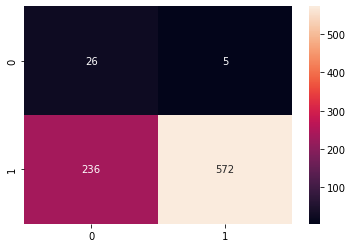

Accuracy of classifier on test set: 0.96


 =======================   Test-ROC    =========================
roc_auc = 0.7777


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.83870968 0.70792079]
average accuracy:  0.7733152347492813


In [61]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0, 
                              learning_rate=0.02, 
                              n_estimators=1000, 
                              algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

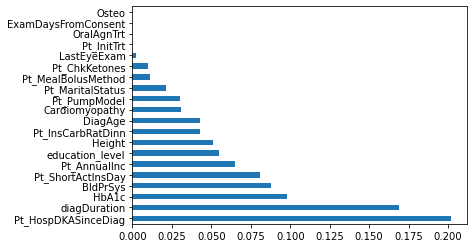

In [62]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 2 on the test set: 0.9563492063492064, doublecheck: 0.9563492063492064
Accuracy for the fold no. 3 on the test set: 0.9523809523809523, doublecheck: 0.9523809523809523
Accuracy for the fold no. 4 on the test set: 0.9603174603174603, doublecheck: 0.9603174603174603
Accuracy for the fold no. 5 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 6 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 7 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 8 on the test set: 0.9601593625498008, doublecheck: 0.9601593625498008
Accuracy for the fold no. 9 on the test set: 0.9601593625498008, doublecheck: 0.9601593625498008
Accuracy for the fold no. 10 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
0.7635340146917917
Threshold 

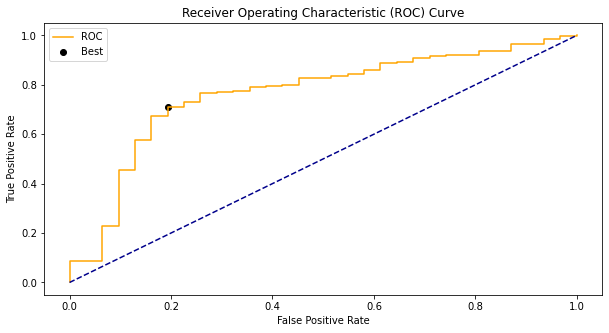

0.9889598966000073
Threshold value is: 1.6677946


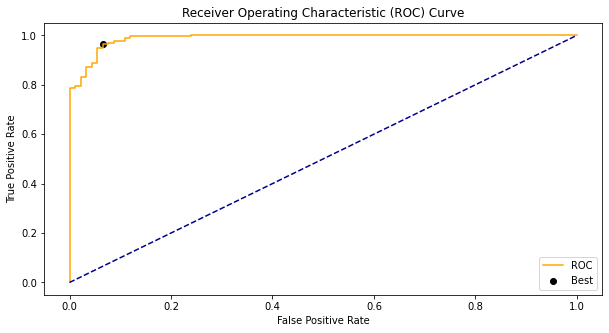


 
 =====================   Train Dataset    ======================
96.45982498011138
              precision    recall  f1-score   support

         0.0       0.51      0.93      0.66        92
         1.0       1.00      0.97      0.98      2422

    accuracy                           0.96      2514
   macro avg       0.75      0.95      0.82      2514
weighted avg       0.98      0.96      0.97      2514



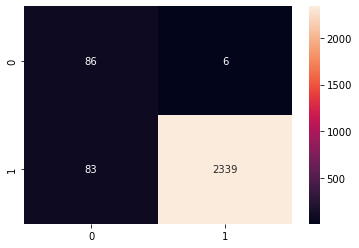

Accuracy of on training set: 0.99


 =====================   Test Dataset    =======================
71.51370679380214
              precision    recall  f1-score   support

         0.0       0.10      0.81      0.17        31
         1.0       0.99      0.71      0.83       808

    accuracy                           0.72       839
   macro avg       0.54      0.76      0.50       839
weighted avg       0.96      0.72      0.80       839



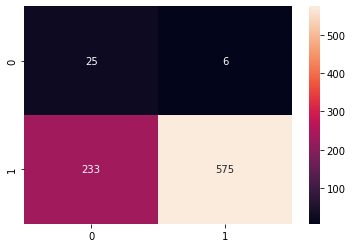

Accuracy of classifier on test set: 0.96


 =======================   Test-ROC    =========================
roc_auc = 0.7635


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.80645161 0.71163366]
average accuracy:  0.7590426381347812


In [63]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 5, #values between(3-10)
        max_delta_step = 10,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
        min_child_weight = 2,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

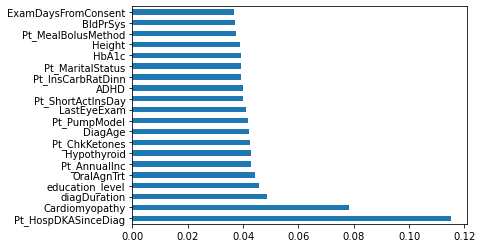

In [64]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.746031746031746, doublecheck: 0.746031746031746
Accuracy for the fold no. 2 on the test set: 0.8412698412698413, doublecheck: 0.8412698412698413
Accuracy for the fold no. 3 on the test set: 0.7698412698412699, doublecheck: 0.7698412698412699
Accuracy for the fold no. 4 on the test set: 0.8611111111111112, doublecheck: 0.8611111111111112
Accuracy for the fold no. 5 on the test set: 0.8207171314741036, doublecheck: 0.8207171314741036
Accuracy for the fold no. 6 on the test set: 0.7609561752988048, doublecheck: 0.7609561752988048
Accuracy for the fold no. 7 on the test set: 0.8047808764940239, doublecheck: 0.8047808764940239
Accuracy for the fold no. 8 on the test set: 0.7928286852589641, doublecheck: 0.7928286852589641
Accuracy for the fold no. 9 on the test set: 0.7729083665338645, doublecheck: 0.7729083665338645
Accuracy for the fold no. 10 on the test set: 0.7928286852589641, doublecheck: 0.7928286852589641
0.7789444267007346
Threshold va

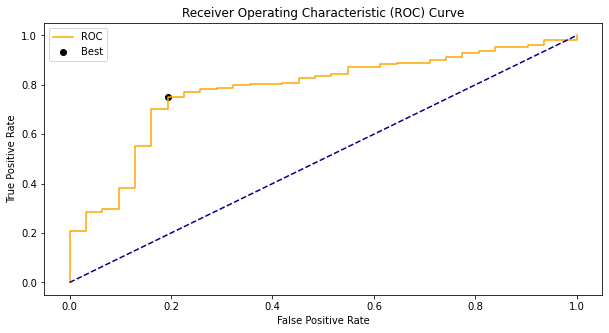

0.9234866980217572
Threshold value is: 0.43890780356792747


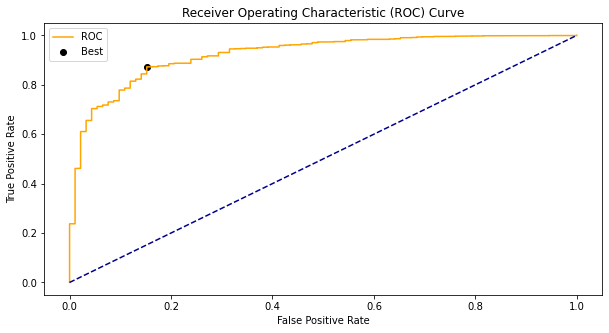


 
 =====================   Train Dataset    ======================
87.15194908512332
              precision    recall  f1-score   support

         0.0       0.20      0.85      0.33        92
         1.0       0.99      0.87      0.93      2422

    accuracy                           0.87      2514
   macro avg       0.60      0.86      0.63      2514
weighted avg       0.96      0.87      0.91      2514



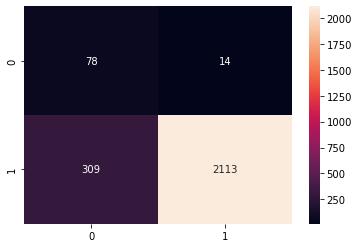

Accuracy of on training set: 0.79


 =====================   Test Dataset    =======================
75.08939213349225
              precision    recall  f1-score   support

         0.0       0.11      0.81      0.19        31
         1.0       0.99      0.75      0.85       808

    accuracy                           0.75       839
   macro avg       0.55      0.78      0.52       839
weighted avg       0.96      0.75      0.83       839



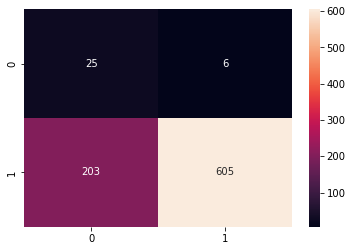

Accuracy of classifier on test set: 0.78


 =======================   Test-ROC    =========================
roc_auc = 0.7789


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.80645161 0.74876238]
average accuracy:  0.7776069945704247


In [65]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=5,
                             n_estimators = feature,
                             criterion = 'gini', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.01,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf)

# find optimal threshold
optimal_threshold = optimal_thresh(rf, X_test, Y_test)
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

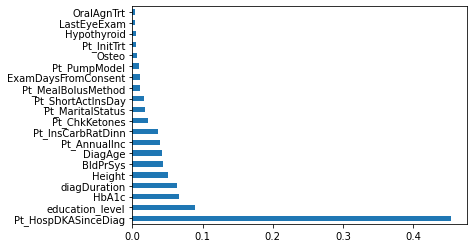

In [66]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.7222222222222222, doublecheck: 0.7222222222222222
Accuracy for the fold no. 2 on the test set: 0.7619047619047619, doublecheck: 0.7619047619047619


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 3 on the test set: 0.753968253968254, doublecheck: 0.753968253968254
Accuracy for the fold no. 4 on the test set: 0.8055555555555556, doublecheck: 0.8055555555555556


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 5 on the test set: 0.7729083665338645, doublecheck: 0.7729083665338645
Accuracy for the fold no. 6 on the test set: 0.7091633466135459, doublecheck: 0.7091633466135459


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 7 on the test set: 0.7051792828685259, doublecheck: 0.7051792828685259
Accuracy for the fold no. 8 on the test set: 0.7569721115537849, doublecheck: 0.7569721115537849


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 9 on the test set: 0.7250996015936255, doublecheck: 0.7250996015936255
Accuracy for the fold no. 10 on the test set: 0.7330677290836654, doublecheck: 0.7330677290836654
0.7610986905142128
Threshold value is: 0.5981173744046465


The max_iter was reached which means the coef_ did not converge


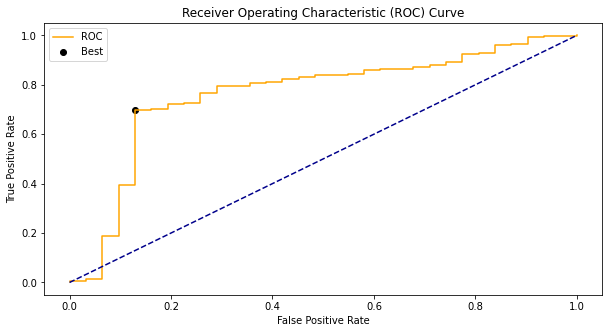

0.8650639069400065
Threshold value is: 0.4575555387363576


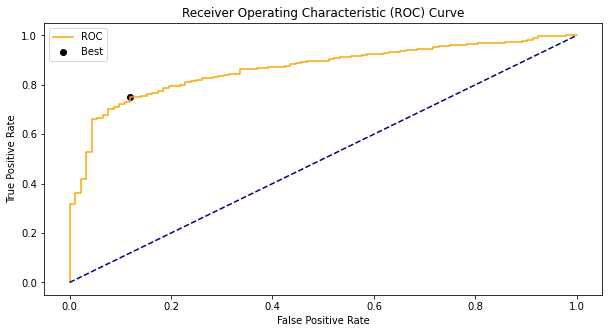


 
 =====================   Train Dataset    ======================
75.33810660302306
              precision    recall  f1-score   support

         0.0       0.12      0.88      0.21        92
         1.0       0.99      0.75      0.85      2422

    accuracy                           0.75      2514
   macro avg       0.56      0.81      0.53      2514
weighted avg       0.96      0.75      0.83      2514



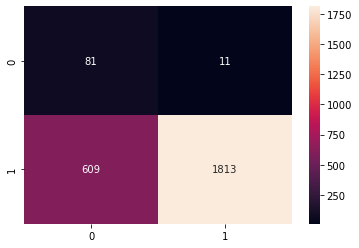

Accuracy of on training set: 0.73


 =====================   Test Dataset    =======================
70.44100119189511
              precision    recall  f1-score   support

         0.0       0.10      0.87      0.18        31
         1.0       0.99      0.70      0.82       808

    accuracy                           0.70       839
   macro avg       0.55      0.78      0.50       839
weighted avg       0.96      0.70      0.80       839



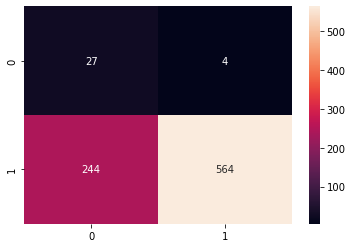

Accuracy of classifier on test set: 0.73


 =======================   Test-ROC    =========================
roc_auc = 0.7611


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.87096774 0.6980198 ]
average accuracy:  0.7844937719578409


In [67]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

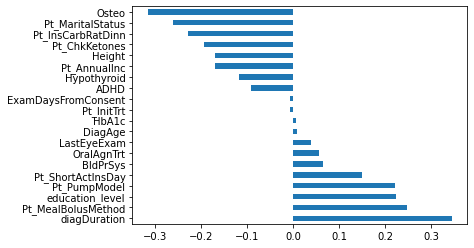

In [68]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.9484126984126984, doublecheck: 0.9484126984126984
Accuracy for the fold no. 2 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 3 on the test set: 0.9523809523809523, doublecheck: 0.9523809523809523
Accuracy for the fold no. 4 on the test set: 0.9563492063492064, doublecheck: 0.9563492063492064
Accuracy for the fold no. 5 on the test set: 0.9482071713147411, doublecheck: 0.9482071713147411
Accuracy for the fold no. 6 on the test set: 0.952191235059761, doublecheck: 0.952191235059761
Accuracy for the fold no. 7 on the test set: 0.9641434262948207, doublecheck: 0.9641434262948207
Accuracy for the fold no. 8 on the test set: 0.9442231075697212, doublecheck: 0.9442231075697212
Accuracy for the fold no. 9 on the test set: 0.9482071713147411, doublecheck: 0.9482071713147411
Accuracy for the fold no. 10 on the test set: 0.9681274900398407, doublecheck: 0.9681274900398407
0.770839987224529
Threshold val

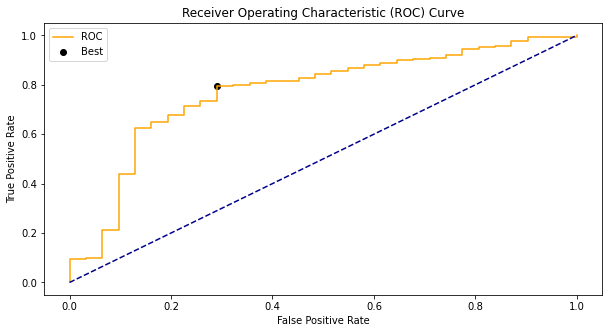

0.8565325099630201
Threshold value is: 0.9673012267155381


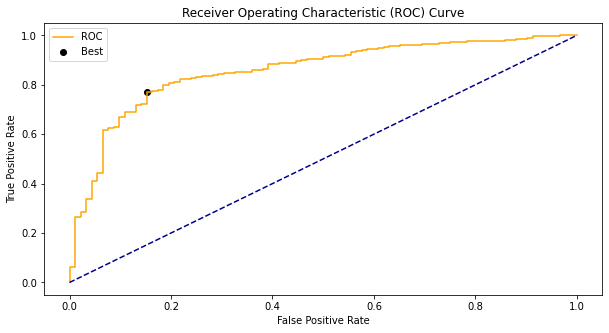


 
 =====================   Train Dataset    ======================
77.44630071599046
              precision    recall  f1-score   support

         0.0       0.12      0.85      0.22        92
         1.0       0.99      0.77      0.87      2422

    accuracy                           0.77      2514
   macro avg       0.56      0.81      0.54      2514
weighted avg       0.96      0.77      0.84      2514



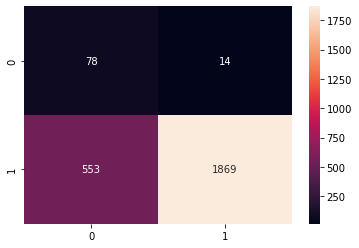

Accuracy of on training set: 0.96


 =====================   Test Dataset    =======================
79.02264600715138
              precision    recall  f1-score   support

         0.0       0.12      0.71      0.20        31
         1.0       0.99      0.79      0.88       808

    accuracy                           0.79       839
   macro avg       0.55      0.75      0.54       839
weighted avg       0.95      0.79      0.85       839



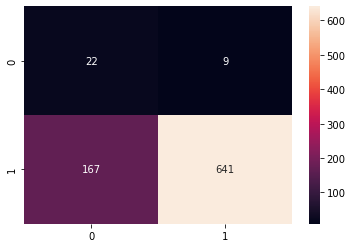

Accuracy of classifier on test set: 0.96


 =======================   Test-ROC    =========================
roc_auc = 0.7708


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.70967742 0.79331683]
average accuracy:  0.7514971255190035


In [69]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(lda, X_test, Y_test)
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


<AxesSubplot:>

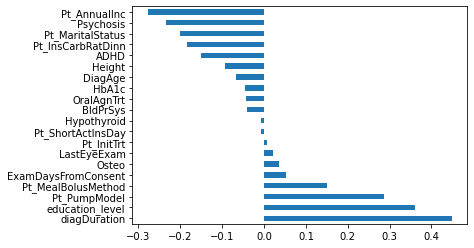

In [70]:
feat_importances = pd.Series(lda.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')


## Model 7- Gaussian Naive Bayes

Accuracy for the fold no. 1 on the test set: 0.9563492063492064, doublecheck: 0.9563492063492064
Accuracy for the fold no. 2 on the test set: 0.9642857142857143, doublecheck: 0.9642857142857143
Accuracy for the fold no. 3 on the test set: 0.9444444444444444, doublecheck: 0.9444444444444444
Accuracy for the fold no. 4 on the test set: 0.9444444444444444, doublecheck: 0.9444444444444444
Accuracy for the fold no. 5 on the test set: 0.952191235059761, doublecheck: 0.952191235059761
Accuracy for the fold no. 6 on the test set: 0.9442231075697212, doublecheck: 0.9442231075697212
Accuracy for the fold no. 7 on the test set: 0.9561752988047809, doublecheck: 0.9561752988047809
Accuracy for the fold no. 8 on the test set: 0.9362549800796812, doublecheck: 0.9362549800796812
Accuracy for the fold no. 9 on the test set: 0.9402390438247012, doublecheck: 0.9402390438247012
Accuracy for the fold no. 10 on the test set: 0.9482071713147411, doublecheck: 0.9482071713147411
0.7463669754072182
Threshold va

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


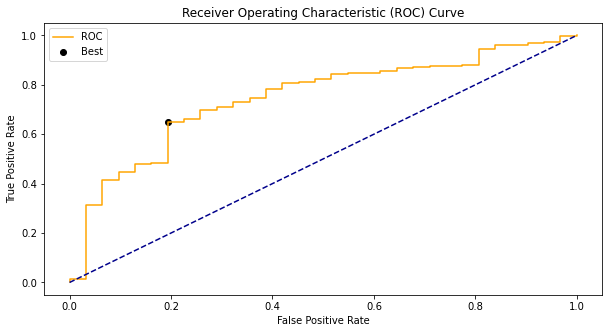

0.8429388216709153
Threshold value is: 0.9944558103862142


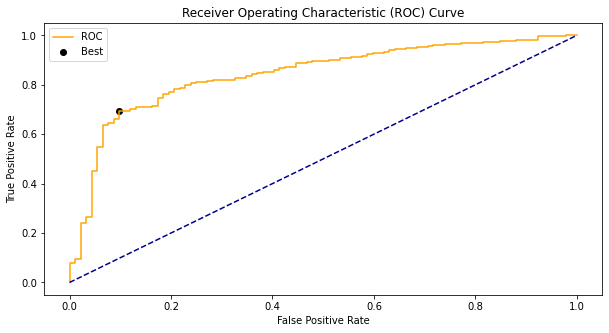


 
 =====================   Train Dataset    ======================
70.12728719172632
              precision    recall  f1-score   support

         0.0       0.10      0.90      0.18        92
         1.0       0.99      0.69      0.82      2422

    accuracy                           0.70      2514
   macro avg       0.55      0.80      0.50      2514
weighted avg       0.96      0.70      0.79      2514



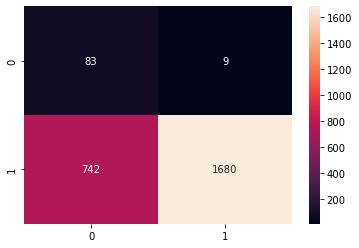

Accuracy of on training set: 0.95


 =====================   Test Dataset    =======================
65.67342073897497
              precision    recall  f1-score   support

         0.0       0.08      0.81      0.15        31
         1.0       0.99      0.65      0.79       808

    accuracy                           0.66       839
   macro avg       0.54      0.73      0.47       839
weighted avg       0.96      0.66      0.76       839



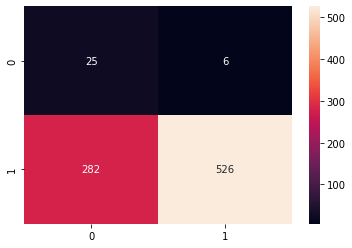

Accuracy of classifier on test set: 0.94


 =======================   Test-ROC    =========================
roc_auc = 0.7464


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.80645161 0.6509901 ]
average accuracy:  0.7287208559565634


In [71]:
gnb = GaussianNB(priors=None, var_smoothing=1.0)

nbModel_grid = cross_val(gnb)

gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


<AxesSubplot:>

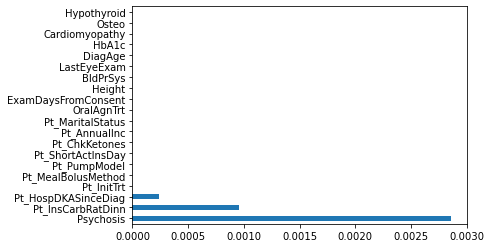

In [72]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb, X_test, Y_test)

feat_importances = pd.Series(imps.importances_mean, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.7867694027467262
Threshold value is: 0.6191221592143382


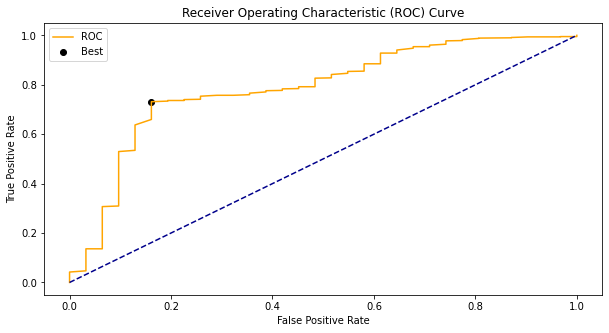



 =====================   Test Dataset    =======================
73.5399284862932
              precision    recall  f1-score   support

         0.0       0.11      0.84      0.19        31
         1.0       0.99      0.73      0.84       808

    accuracy                           0.74       839
   macro avg       0.55      0.79      0.52       839
weighted avg       0.96      0.74      0.82       839



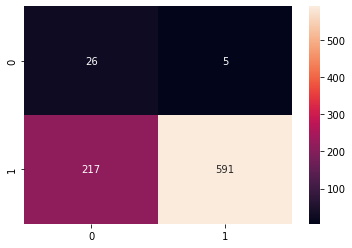

Accuracy of classifier on test set: 0.96


 =======================   Test-ROC    =========================
roc_auc = 0.7868


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.83870968 0.73143564]
average accuracy:  0.7850726604918556
BoostedRules:
Rule → predicted probability (final prediction is weighted sum of all predictions)
  If Pt_HospDKASinceDiag <= 0.33188 → 1.00 (weight: 1.64)
  If Pt_HospDKASinceDiag > 0.33188 → 0.68 (weight: 0.74)
  If Pt_HospDKASinceDiag <= 0.33188 → 1.00 (weight: 0.23)
  If Pt_HospDKASinceDiag > 0.33188 → 0.24 (weight: 0.14)
  If diagDuration <= -0.25265 → 0.57 (weight: 0.20)
  If diagDuration > -0.25265 → 0.92 (weight: 0.18)
  If education_level <= 0.65908 → 0.93 (weight: 0.09)
  If education_level > 0.65908 → 0.17 (weight: 0.19)
  If diagDuration <= -0.25265 → 1.00 (weight: 0.06)
  If diagDuration > -0.25265 → 0.87 (weight: 0.09)
  If Pt_AnnualInc <= 1.38822 → 0.09 (weight: 0.14)
  I

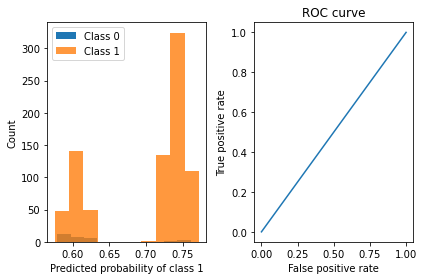

In [73]:
from imodels import BoostedRulesClassifier, FIGSClassifier, SkopeRulesClassifier
def viz_classification_preds(probs, y_test):
    '''look at prediction breakdown
    '''
    plt.subplot(121)
    plt.hist(probs[:, 1][y_test == 0], label='Class 0')
    plt.hist(probs[:, 1][y_test == 1], label='Class 1', alpha=0.8)
    plt.ylabel('Count')
    plt.xlabel('Predicted probability of class 1')
    plt.legend()

    plt.subplot(122)
    preds = np.argmax(probs, axis=1)
    plt.title('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(fpr, tpr)
    plt.tight_layout()
    plt.show()

# fit boosted stumps
brc = BoostedRulesClassifier(n_estimators=20)
brc.fit(X_train, Y_train, feature_names=X_train.columns)

optimal_threshold = optimal_thresh(brc, X_test, Y_test)
# optimal_threshold_train= optimal_thresh(brc, X_train, Y_train)

pred = (brc.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
# pred_train = (brc.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


# train_results(brc, X_train, Y_train, pred_train)
test_results(brc, X_test, Y_test, pred)

# ROC
ROC_results(brc, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(brc, Y_test, pred)

print(brc)

# look at performance
probs = brc.predict_proba(X_test)
viz_classification_preds(probs, Y_test)

In [74]:
d = pd.DataFrame(Y_test).head(100)
# s = d[d.DKAPast12mos == 0.0]
# for index, row in d.iterrows():
#     if row.DKAPast12mos == 0.0:
#         print(index)
d      

,DKAPast12mos
23108,1.0
16752,1.0
18914,1.0
24887,1.0
5226,1.0
12144,1.0
5295,1.0
12258,1.0
14851,1.0
16551,0.0


## SHAP Values

In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


my_model = RandomForestClassifier(random_state=0).fit(X_train, Y_train)

row_to_show = 93
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = my_model.predict(data_for_prediction_array)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
my_model.predict_proba(data_for_prediction_array)

import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)


shap.initjs()

# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


predictoin [1.]
actial 1.0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


NOTE: How do you interpret shap

We predicted 0.7, whereas the base_value is 0.4979. Feature values causing increased predictions are in pink, and their visual size shows the magnitude of the feature's effect. Feature values decreasing the prediction are in blue. The biggest impact comes from weight being -0.9503. Though the pt_hospDKASinceDiag value has a meaningful effect decreasing the prediction.